# ⚠️ Anomaly detection in network traffic data using Isolation Forest


## 1. 📚 All the necessary imports


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## 2. 📥 Load the dataset and check its metadata and visualize it


In [2]:
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]

df = pd.read_csv("Dataset/kddcup.data_10_percent.gz", names=column_names)

In [3]:
# first few rows

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
# all the columns

df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [5]:
# shape of the dataset (row, column)

df.shape

(494021, 42)

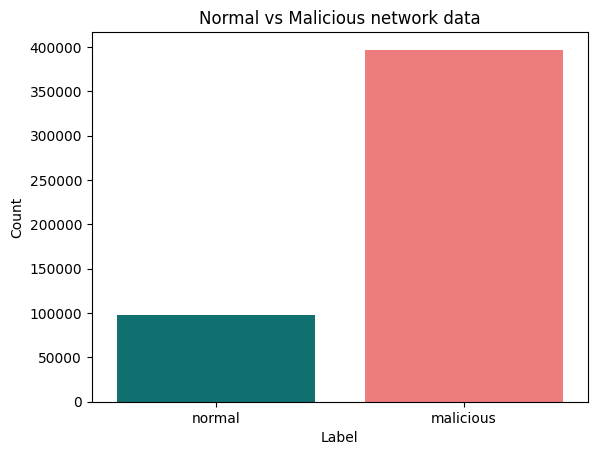

In [6]:
# bar graph to see number of normal and malicious network data

df["binary_label"] = df["label"].apply(
    lambda x: "normal" if x == "normal." else "malicious"
)

sns.countplot(
    data=df, x="binary_label", hue="binary_label", palette=["#008080", "#FF6B6B"]
)
plt.title("Normal vs Malicious network data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## 2. 🎯 Filter only the normal data for training

-   For unsupervised learning, we have to remove the malicious data, because we have to make sure our model learns what `normal` looks like.
-   Isolation forest learns what normal data looks like based on the structure, distribution, and patterns.
-   This model will predict a new data to be normal if it follows similar patterns, or malicious, if it is different from the normal data.


In [7]:
df_normal = df[df["label"] == "normal."]

In [8]:
df_normal.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [9]:
df_normal.shape

(97278, 43)

## 3. 🧹 Preprocessing

-   We have to drop the target labels, because it is unsupervised learning.
-   They won't affect the learning as they are not features.
-   We have to seperate categorical and numerical columns for preprocessing.


In [10]:
x = df_normal.drop(labels=["label", "binary_label"], axis=1)

In [11]:
x.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [12]:
categorical_columns = x.select_dtypes(exclude=["number"]).columns
numerical_columns = x.select_dtypes(include=["number"]).columns

preprocessor = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("scaler", StandardScaler(), numerical_columns),
    ]
)

x_preprocessed = preprocessor.fit_transform(x)

## 4. 🌲 Build the Isolation Forest model

-   We are using `contamination` parameter value as `auto`.
-   Typically this threshold ranges from 0.0 to 0.5.
-   By choosing `auto`, the model will adjust it's value upon training, and we do not have to fine tune it.


In [13]:
isolation_forest = IsolationForest(contamination="auto", random_state=42)
isolation_forest.fit(x_preprocessed)

,n_estimators,100
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


## 📊 5. Evaluation on mixed test data


In [14]:
df_test = pd.read_csv("Dataset/corrected.gz", names=column_names)

x_test = df_test.drop("label", axis=1)
y_test = df_test["label"].apply(lambda x: 0 if x == "normal." else 1)

x_test_preprocessed = preprocessor.transform(x_test)

In [15]:
y_pred = isolation_forest.predict(x_test_preprocessed)
y_pred = [0 if i == 1 else 1 for i in y_pred]

## 6. 📈 Visualize Predicted labels vs Actual labels


In [16]:
y_test_series = pd.Series(y_test, name="Actual")
y_pred_series = pd.Series(y_pred, name="Predicted")

In [17]:
actual_counts = y_test_series.value_counts().sort_index()
predicted_counts = y_pred_series.value_counts().sort_index()

### i. Bar graph


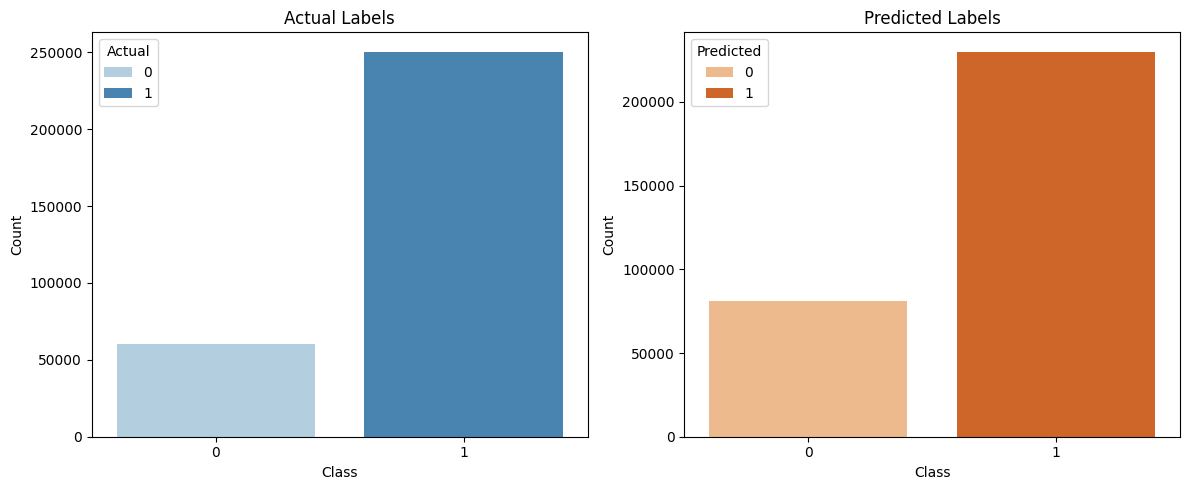

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# actual labels
sns.barplot(
    x=actual_counts.index,
    y=actual_counts.values,
    ax=axes[0],
    palette="Blues",
    hue=actual_counts.index,
)
axes[0].set_title("Actual Labels")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# predicted labels
sns.barplot(
    x=predicted_counts.index,
    y=predicted_counts.values,
    ax=axes[1],
    palette="Oranges",
    hue=predicted_counts.index,
)
axes[1].set_title("Predicted Labels")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

### ii. Count Plot


In [19]:
comparision_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

melted_df = comparision_df.melt(var_name="Type", value_name="Label")

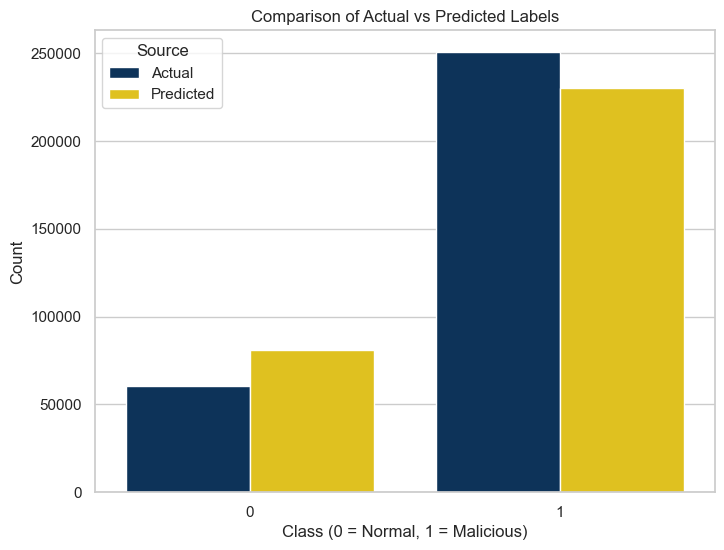

In [20]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(data=melted_df, x="Label", hue="Type", palette=["#003366", "#FFD700"])

plt.title("Comparison of Actual vs Predicted Labels")
plt.xlabel("Class (0 = Normal, 1 = Malicious)")
plt.ylabel("Count")
plt.legend(title="Source")
plt.show()

## 7. 📈 Evaluation with Metrics


### i. ✔️ Classification report


In [21]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.73      0.97      0.83     60593
           1       0.99      0.91      0.95    250436

    accuracy                           0.92    311029
   macro avg       0.86      0.94      0.89    311029
weighted avg       0.94      0.92      0.93    311029



### ii. 😵 Confusion matrix


In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 58953   1640]
 [ 21974 228462]]


## 8. 🛞 Visualize with Confusion matrix Heatmap


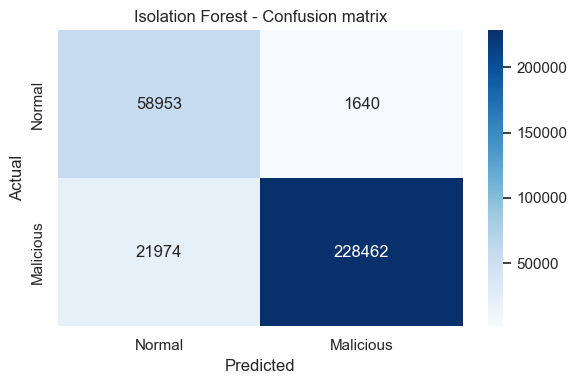

In [23]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    yticklabels=["Normal", "Malicious"],
    xticklabels=["Normal", "Malicious"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest - Confusion matrix")
plt.tight_layout()
plt.show()

## ⬇️ 9. Save the model and preprocessor


In [24]:
pipeline = {
    "preprocessor": preprocessor,
    "model": isolation_forest,
}

joblib.dump(pipeline, "isolation_forest.joblib")

['isolation_forest.joblib']